### Hypothesis
#### **A large trades on Binance precedes a large, price moving trade on HyperLiquid**

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.set_option('expand_frame_repr', False)
from statsmodels.stats.proportion import proportions_ztest

In [20]:
# Load HyperLiquid trades data
hl_file_paths = [
    "C:/Users/trgrd/OneDrive/Trading/Projects/data_download/data/ETH/ETH_trade_20240418.pkl",
    "C:/Users/trgrd/OneDrive/Trading/Projects/data_download/data/ETH/ETH_trade_20240419.pkl",
    "C:/Users/trgrd/OneDrive/Trading/Projects/data_download/data/ETH/ETH_trade_20240420.pkl"
]
hl_trade_list = [pd.DataFrame(pd.read_pickle(path)) for path in hl_file_paths]
hl_trades = pd.concat(hl_trade_list, ignore_index=True)
hl_trades.reset_index(drop=True, inplace=True)

# Data preparation
hl_trades['px'] = pd.to_numeric(hl_trades['px'], errors='coerce')
hl_trades['sz'] = pd.to_numeric(hl_trades['sz'], errors='coerce')
hl_trades['time'] = pd.to_datetime(hl_trades['time'], unit='ms')

# Load Binance trades data
binance_file_paths = [
    "C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-04-18.csv",
    "C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-04-19.csv",
    "C:/Users/trgrd/OneDrive/Trading/Projects/data_download/Binance_data/ETHUSDT-trades-2024-04-20.csv"
]

binance_trade_list = [pd.read_csv(path, sep=",", header=None, names=["trade_id", "price", "quantity", "quote_quantity", "timestamp", "is_buyer_maker", "ignore"]) for path in binance_file_paths]

# Concatenate all Binance trade DataFrames into one
binance_trades = pd.concat(binance_trade_list, ignore_index=True)
binance_trades.reset_index(drop=True, inplace=True)
binance_trades['timestamp'] = pd.to_datetime(binance_trades['timestamp'], unit='ms')

In [21]:
# Set Index and Trim DataFrames
# Set the time as the index for Binance trades
binance_trades.set_index('timestamp', inplace=True)

# Do the same for HL trades
hl_trades.set_index('time', inplace=True)

# Get the start and end times
binance_start_time = binance_trades.index.min()
hl_end_time = hl_trades.index.max()

# Trim trades to start from the Binance start time
hl_trades = hl_trades[hl_trades.index >= binance_start_time]
binance_trades = binance_trades[binance_trades.index <= hl_end_time]

# Resample trades to 1-second intervals by summing quantity per second
binance_resampled = binance_trades['quantity'].resample('1s').sum()
hl_resampled = hl_trades['sz'].resample('1s').sum()
hl_price_resampled = hl_trades['px'].resample('1s').last()

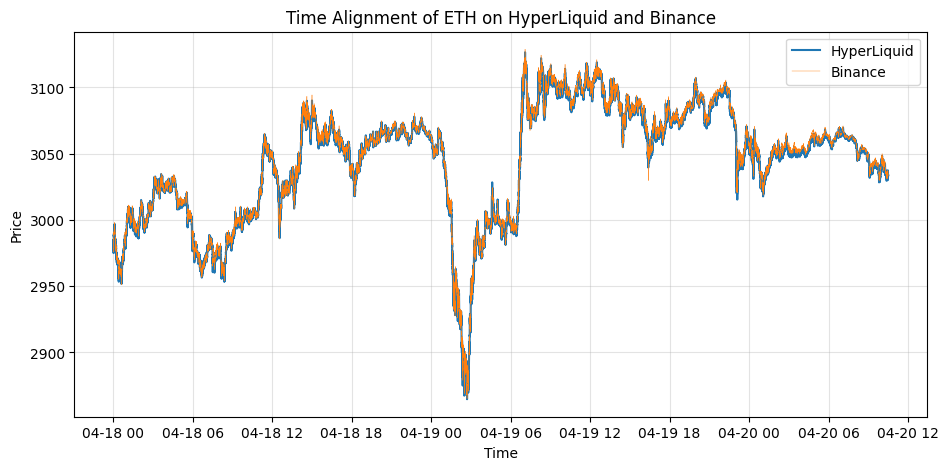

In [30]:
# Plot to confirm alignment of price between the exchanges
plt.figure(figsize=(11, 5))
plt.plot(hl_trades['px'], label='HyperLiquid')
plt.plot(binance_trades['price'], lw=0.3, label='Binance')
plt.grid(alpha=0.35)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Time Alignment of ETH on HyperLiquid and Binance')
plt.legend()
plt.show()

In [31]:
# Define the percentile for large trades
binance_quantile = 0.95
hl_quantile = 0.95

# Compute the percentile threshold for trade size
binance_trade_size_threshold = binance_resampled.quantile(binance_quantile)
hl_trade_size_threshold = hl_resampled.quantile(hl_quantile)

# Filter resampled trades to get large trades
binance_large_trades = binance_resampled[binance_resampled >= binance_trade_size_threshold]
hl_large_trades = hl_resampled[hl_resampled >= hl_trade_size_threshold]

# Extract timestamps of large trades
binance_large_trade_times = binance_large_trades.index
hl_large_trade_times = hl_large_trades.index


print(f"Binance Large Trades Count: {len(binance_large_trade_times)}")
print(f"HL Large Trades Count: {len(hl_large_trade_times)}")

Binance Large Trades Count: 10530
HL Large Trades Count: 10530


In [40]:
# Identify HL Trades that Move the Price
# Define parameters for price movement
price_move_threshold = 0.001
price_move_window = 60  # seconds

hl_price_moving_trades = []
for trade_time in hl_large_trade_times:
    # Define the window end time
    window_end_time = trade_time + pd.Timedelta(seconds=price_move_window)
    
    # Ensure the window does not exceed the dataset
    if window_end_time > hl_price_resampled.index.max():
        continue
    
    # Get the price at trade time
    trade_price = hl_price_resampled.loc[trade_time]
    
    # Get the price at window end time
    end_price = hl_price_resampled.loc[window_end_time]
    
    # Calculate the percentage change
    pct_change = (end_price - trade_price) / trade_price
    
    # Check if the price movement exceeds the threshold
    if abs(pct_change) >= price_move_threshold:
        hl_price_moving_trades.append(trade_time)
        
print(f"HL Trades that Moved the Price: {len(hl_price_moving_trades)}")

HL Trades that Moved the Price: 2928


In [41]:
# Analyze Temporal Relationship

# Define the pre-event window
pre_event_window = 60  # seconds

# Initialize a list to store whether a large Binance trade occurred before each HL price-moving trade
binance_precedes_hl = []

for hl_trade_time in hl_price_moving_trades:
    # Define the window start time
    window_start_time = hl_trade_time - pd.Timedelta(seconds=pre_event_window)
    
    # Get Binance large trades within the pre-event window
    binance_trades_before = binance_large_trade_times[
        (binance_large_trade_times >= window_start_time) & 
        (binance_large_trade_times < hl_trade_time)
    ]
    
    # Check if any Binance large trade occurred before the HL trade within the window
    if len(binance_trades_before) > 0:
        binance_precedes_hl.append(1)  # Yes, a large Binance trade occurred before
    else:
        binance_precedes_hl.append(0)  # No large Binance trade occurred before

# Create a DataFrame with this
hl_events_df = pd.DataFrame({
    'hl_trade_time': hl_price_moving_trades,
    'binance_precedes_hl': binance_precedes_hl
})

print(hl_events_df['binance_precedes_hl'].value_counts())

binance_precedes_hl
1    2691
0     237
Name: count, dtype: int64


In [42]:
# Descriptive Statistics

total_hl_events = len(hl_events_df)
binance_precedes = hl_events_df['binance_precedes_hl'].sum()

print(f"Total HL Price-Moving Trades: {total_hl_events}")
print(f"HL Trades Preceded by Large Binance Trades: {binance_precedes}")
print(f"Proportion: {binance_precedes / total_hl_events * 100:.2f}%")

# One-Sample Proportion Test
# H0: proportion = 0.5
count = binance_precedes
nobs = total_hl_events
H0 = 0.5  # Null hypothesis proportion

stat, pval = proportions_ztest(count, nobs, H0)
print(f"Proportion Z-Statistic: {stat:.4f}, P-value: {pval:.4f}")

Total HL Price-Moving Trades: 2928
HL Trades Preceded by Large Binance Trades: 2691
Proportion: 91.91%
Proportion Z-Statistic: 83.1379, P-value: 0.0000


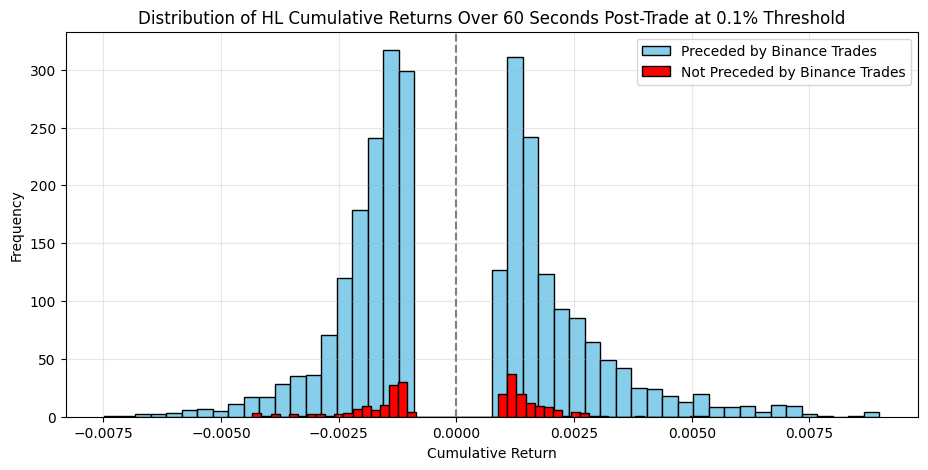

In [48]:
# Visualization of Cumulative Returns

# Initialize lists to store cumulative returns based on Binance precedence
cumulative_returns_preceded = []
cumulative_returns_not_preceded = []

for idx, row in hl_events_df.iterrows():
    hl_trade_time = row['hl_trade_time']
    window_end_time = hl_trade_time + pd.Timedelta(seconds=price_move_window)
    
    # Ensure window_end_time is within the dataset
    if window_end_time > hl_price_resampled.index.max():
        continue  # Skip if out of bounds
    
    # Get the price at trade time and window end time
    trade_price = hl_price_resampled.loc[hl_trade_time]
    end_price = hl_price_resampled.loc[window_end_time]
    
    # Calculate the cumulative return
    pct_change = (end_price - trade_price) / trade_price
    
    if row['binance_precedes_hl'] == 1:
        cumulative_returns_preceded.append(pct_change)
    else:
        cumulative_returns_not_preceded.append(pct_change)

# Create separate DataFrames for visualization
cumulative_returns_df_preceded = pd.DataFrame({
    'cumulative_return': cumulative_returns_preceded
})

cumulative_returns_df_not_preceded = pd.DataFrame({
    'cumulative_return': cumulative_returns_not_preceded
})

# Plot Histogram
plt.figure(figsize=(11, 5))
plt.hist(cumulative_returns_df_preceded['cumulative_return'], bins=50, label='Preceded by Binance Trades', color='skyblue', edgecolor='black')
plt.hist(cumulative_returns_df_not_preceded['cumulative_return'], bins=50, label='Not Preceded by Binance Trades', color='red', edgecolor='black')
plt.axvline(0, color='gray', ls='--')
plt.title(f'Distribution of HL Cumulative Returns Over 60 Seconds Post-Trade at {price_move_threshold * 100}% Threshold')
plt.xlabel('Cumulative Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()